## Project Set Up

Run the code below in a google colab to get the necessary data. 

Here is the data from Kaggle:
https://www.kaggle.com/datasets/adityajn105/flickr8k?select=Images

In [42]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flickr8k:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F623289%2F1111676%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240313%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240313T214715Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D91e893cb73fca2417c97ddefb7d6117b11cada96bd11cbaae9ad981fba5d1fee5c32331965bce79e503447efc290f75d32775fd13e0138c0569df243e2ec013598358ff804499eff093813ab408285e0be5b67e83e49ab85b05fa74b03732e87189059287ebbf4aeb21aade7d35cc28c4368967061734247a12452f48a0dce799f01ffb340a1c817302318cc8da65cdc72a7a8c8c991865808f7dd169ef288de1d366fed14c15792d7e3b66323ba4d65db7eb172971ac43baaa1953cac1c207129af361a9ba08d8fb9d39d3a345c6341794922e24d12a4ffdc8e1385862a7a5ad1d5d5b6ee56fa158e914f0e533b4367f910b26a6927d189e44dec45be72f8d1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1112971163 bytes downloaded
Downloaded and uncompressed: flickr8k
Data source import complete.


## Import Modules

VGG-16 is a 16 layer deep CNN architecture used for images, and preprocess_input is for preprocessing the image data for the VGG-16.

load_img and img_to_array are used for image preprocessing

Tokenizer is used for text preprocessing

pad_sequences is preprocessing to pad the input sequences to the same length

to_categorical converts a numpy array containing catergorical data to an array of binary values and columns that represents the categories.

plot_model is used to visualize the model




In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from nltk.translate.bleu_score import corpus_bleu


Setting Directories

In [3]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

## Feature Extraction

In [45]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [46]:
# Create an empty dictionary to store the extracted features from images
features = {}

# Define the directory where the images are located
directory = os.path.join(BASE_DIR, 'Images')

# Iterate through each image in the directory
for img_name in tqdm(os.listdir(directory)):
    # Load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))

    # Convert the image pixels to a numpy array
    image = img_to_array(image)

    # Reshape the image data to match the input shape of the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Preprocess the image data for compatibility with VGG16 model
    image = preprocess_input(image)

    # Extract features from the preprocessed image using the pre-trained VGG16 model
    feature = model.predict(image, verbose=0)

    # Extract the unique identifier (ID) for the image (remove file extension)
    image_id = img_name.split('.')[0]

    # Store the extracted features in the dictionary with the image ID as the key
    features[image_id] = feature


  0%|          | 0/8091 [00:00<?, ?it/s]

In [6]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [7]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)


## Load the Captions Data

In [8]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

## Preprocess Text Data

In [10]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [11]:
def clean(mapping):
    # Iterate over each image identifier and its associated captions
    for key, captions in mapping.items():
        # Iterate over each caption for the current image
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]

            # Preprocessing steps to clean the caption:
            # Convert the caption to lowercase
            caption = caption.lower()

            # Remove any characters that are not letters (alphabets)
            caption = caption.replace('[^A-Za-z]', '')

            # Remove additional spaces
            caption = caption.replace('\s+', ' ')

            # Add start and end tags to the caption to indicate the beginning and end of a sentence
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'

            # Update the cleaned caption in the list of captions for the current image
            captions[i] = caption


In [12]:
# Before preprocess
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
# After preprocess
clean(mapping)
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
len(all_captions)

40455

In [15]:
# Initialize a Tokenizer object
tokenizer = Tokenizer()

# Fit the tokenizer on the list of all captions to create a vocabulary
tokenizer.fit_on_texts(all_captions)

# Determine the size of the vocabulary by counting unique words in the tokenizer's word index and adding 1
# Adding 1 is necessary because the word index is zero-indexed, and we need to account for the special padding token
vocab_size = len(tokenizer.word_index) + 1

# Return the determined vocabulary size
vocab_size


8485

In [16]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [17]:
# Extract the list of image identifiers (keys) from the mapping dictionary
image_ids = list(mapping.keys())

# Define the proportion of data to be allocated for training (90%) and testing (10%)
split = int(len(image_ids) * 0.70)

# Split the image identifiers into training and testing sets based on the defined split point
train = image_ids[:split]  # Take the first 90% of image identifiers for training
test = image_ids[split:]   # Take the remaining 10% of image identifiers for testing


In [18]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  # Calculate the total number of samples (image keys)
  num_samples = len(data_keys)

  # Loop indefinitely to yield batches of data
  while True:
      # Iterate over the data keys in batches
      for start in range(0, num_samples, batch_size):
          # Determine the end index of the current batch
          end = min(start + batch_size, num_samples)

          # Extract the keys for the current batch
          batch_keys = data_keys[start:end]

          # Initialize lists to store data for the current batch
          X1, X2, y = [], [], []

          # Iterate over each key in the current batch
          for key in batch_keys:
              # Retrieve captions associated with the current key
              captions = mapping[key]

              # Process each caption
              for caption in captions:
                  # Encode the sequence of words in the caption
                  seq = tokenizer.texts_to_sequences([caption])[0]

                  # Generate input-output pairs by splitting the sequence
                  for i in range(1, len(seq)):
                      in_seq, out_seq = seq[:i], seq[i]

                      # Pad the input sequence to match the maximum length
                      in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                      # Encode the output sequence using one-hot encoding
                      out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                      # Append the encoded sequences to the respective lists
                      X1.append(features[key][0])  # Image features
                      X2.append(in_seq)             # Padded input sequence
                      y.append(out_seq)             # Encoded output sequence (one-hot)

          # Convert the lists of data into numpy arrays
          X1, X2, y = np.array(X1), np.array(X2), np.array(y)

          # Yield the batch data as a tuple of input features and output labels
          yield [X1, X2], y


## Model Creation

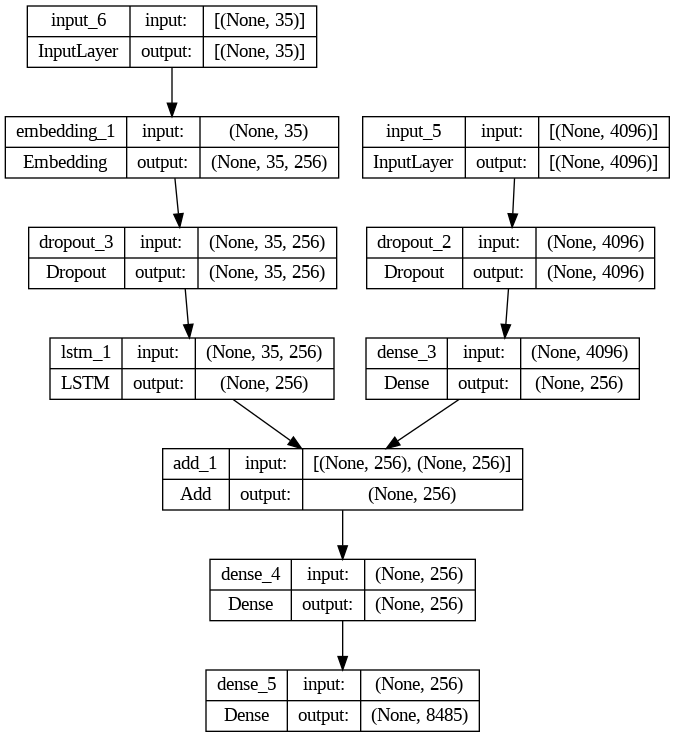

In [52]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [53]:
# train the model
epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

176/176 [==============================] - 27s 150ms/step - loss: 1.6210


In [54]:
# Save the model
model.save(WORKING_DIR + '/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Generate Captions for Image

In [55]:
from keras.models import load_model

# Load the saved model
loaded_model = load_model(WORKING_DIR + '/best_model.h5')

In [56]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
          return word
    return None

In [58]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [31]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(loaded_model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/2428 [00:00<?, ?it/s]

BLEU-1: 0.500018
BLEU-2: 0.279649


## Visualize the Results

In [59]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(loaded_model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing with each other in the street endseq


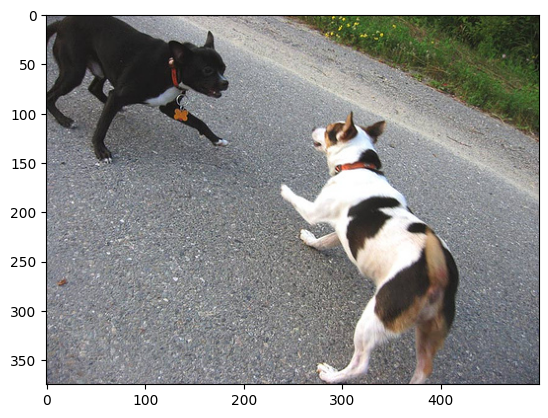

In [60]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq young couple inspect merchandise from street vendor endseq
startseq people are gathering around table of food and outside taxi wisks by endseq
startseq three people prepare table full of food with police car in the background endseq
startseq two people look at street vendor endseq
startseq two women and man at food counter in dim lights endseq
--------------------Predicted--------------------
startseq people gather around street vendor at food counter endseq


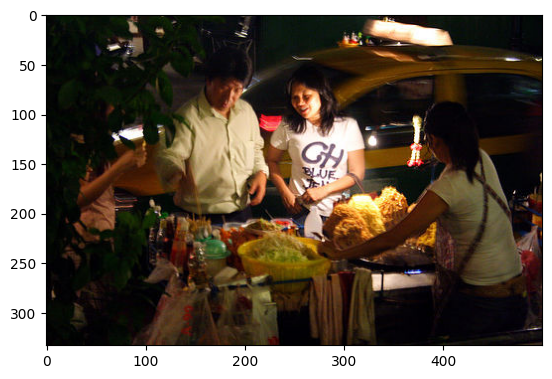

In [61]:
generate_caption("33108590_d685bfe51c.jpg")

---------------------Actual---------------------
startseq black dog carries green toy in his mouth as he walks through the grass endseq
startseq black dog carrying something through the grass endseq
startseq black dog has blue toy in its mouth endseq
startseq dog in grass with blue item in his mouth endseq
startseq wet black dog is carrying green toy through the grass endseq
--------------------Predicted--------------------
startseq black dog carries green toy in his mouth in the grass endseq


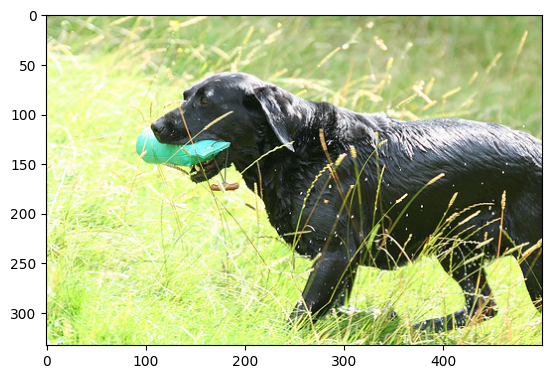

In [62]:
generate_caption("1026685415_0431cbf574.jpg")

---------------------Actual---------------------
startseq people sit on the mountainside and check out the view endseq
startseq three people are on hilltop overlooking green valley endseq
startseq three people hang out on top of big hill endseq
startseq three people overlook green valley endseq
startseq three people rest on ledge above the moutains endseq
--------------------Predicted--------------------
startseq group of people sit on top of mountain endseq


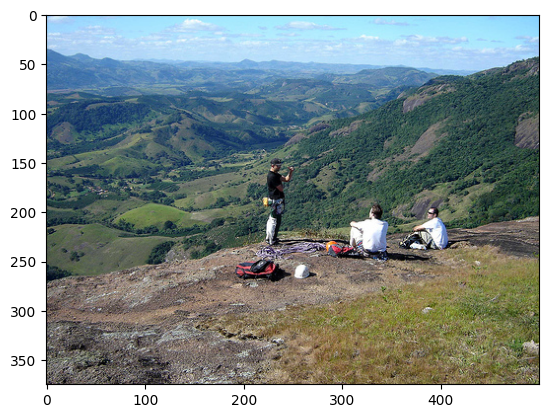

In [63]:
generate_caption("104136873_5b5d41be75.jpg")

---------------------Actual---------------------
startseq blond woman in blue shirt appears to wait for ride endseq
startseq blond woman is on the street hailing taxi endseq
startseq "a woman is signaling is to traffic as seen from behind ." endseq
startseq woman with blonde hair wearing blue tube top is waving on the side of the street endseq
startseq the woman in the blue dress is holding out her arm at oncoming traffic endseq
--------------------Predicted--------------------
startseq woman in blue top is standing in the street hailing taxi endseq


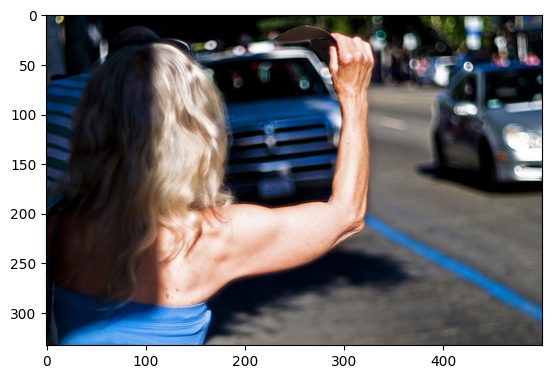

In [64]:
generate_caption("1056338697_4f7d7ce270.jpg")

---------------------Actual---------------------
startseq group of eight people are gathered around table at night endseq
startseq group of people gathered around in the dark endseq
startseq group of people sit around table outside on porch at night endseq
startseq group of people sit outdoors together at night endseq
startseq group of people sitting at table in darkened room endseq
--------------------Predicted--------------------
startseq group of people gathered around table in dark room endseq


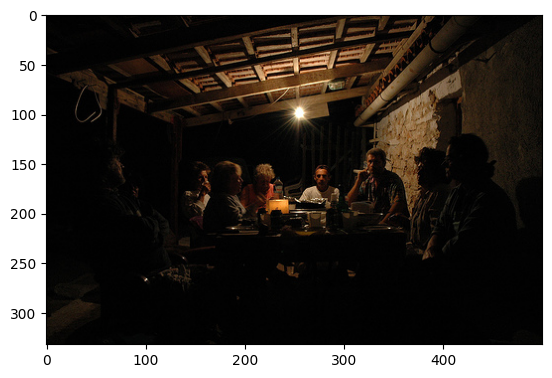

In [65]:
generate_caption("107582366_d86f2d3347.jpg")

---------------------Actual---------------------
startseq man dressed in green jacket is playing piano while woman sings endseq
startseq "a man is sitting in front of harpsichord and woman is preparing to sing ." endseq
startseq person playing the piano with singer nearby endseq
startseq pianist and singer are ready to perform endseq
startseq the man in the green jacket is playing the piano next to woman who is by music stand endseq
--------------------Predicted--------------------
startseq two women are sitting at table in room full of art endseq


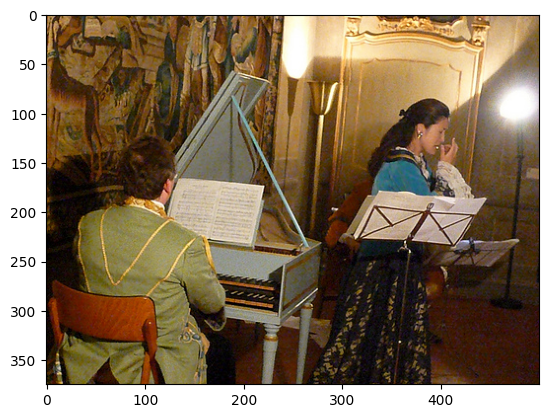

In [66]:
generate_caption("3543378438_47e2712486.jpg")

---------------------Actual---------------------
startseq black boy and white boy in swimming trunks are hugging each other on beach or lake endseq
startseq white boy and black boy embrace endseq
startseq two boys in red swim trunks hold each other in the water endseq
startseq two kids are hugging playfully in shallow water endseq
startseq two kids are standing in the ocean hugging each other endseq
--------------------Predicted--------------------
startseq four girls are playing in the ocean at beach endseq


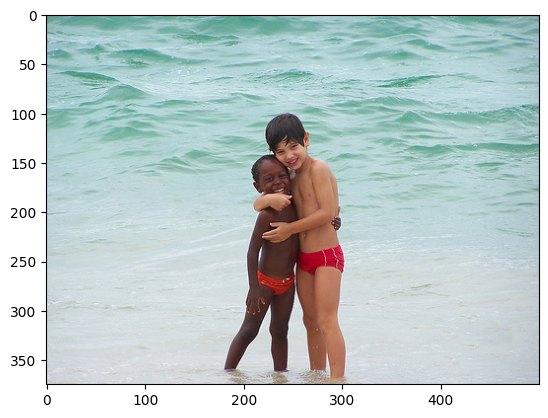

In [68]:
generate_caption("812196663_0c969970b5.jpg")

---------------------Actual---------------------
startseq girl walking with her grey umbrella endseq
startseq woman holding an umbrella is standing near parking meter endseq
startseq woman is walking down the street holding an umbrella endseq
startseq woman with blue umbrella stands next to parking meter endseq
startseq "a woman in heels black skirt and white shirt holds her blue umbrella over her head while walking on sidewalk near parking meter ." endseq
--------------------Predicted--------------------
startseq boy in striped shirt jumping on ramp in the snow endseq


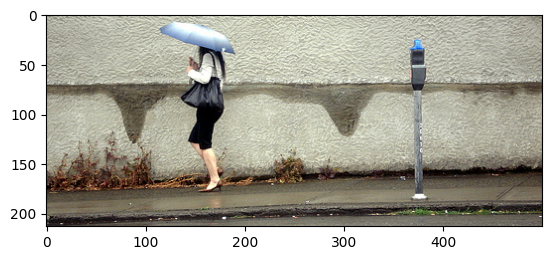

In [70]:
generate_caption("842961005_692737888e.jpg")

---------------------Actual---------------------
startseq "large group of people most setting down on walkway with two boys standing up holding plates ." endseq
startseq many people are sitting and observing or going into water attraction endseq
startseq many people sit or stand around the fountain near the space needle endseq
startseq "people sit by fountain guy with purple hair talks to guy in hat ." endseq
startseq "two men one with purple hair at crowded fountain near seattle space needle ." endseq
--------------------Predicted--------------------
startseq group of people in front of crowd of people watching in front of building endseq


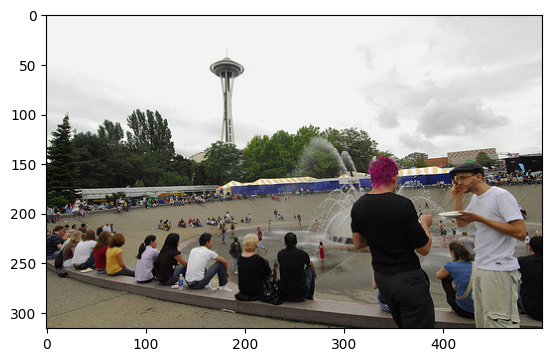

In [71]:
generate_caption("872512911_ca383b40e4.jpg")

---------------------Actual---------------------
startseq man in black shirt enjoys snack while woman in white shirt looks confused endseq
startseq man is eating from paper cone while woman stands behind him endseq
startseq man is standing in front of woman while eating something endseq
startseq one dark-skinned man is eating french fries and blond woman is standing behind him endseq
startseq the man white purple and white polka-dotted shirts is eating and looking to his right while the woman behind him has confused look on her face endseq
--------------------Predicted--------------------
startseq two girls are standing in front of two plants and one girl in the foreground endseq


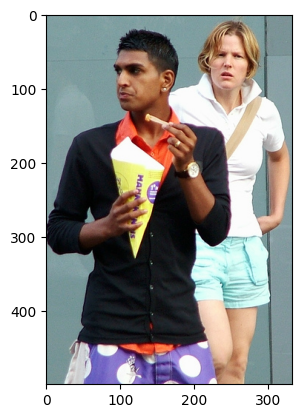

In [72]:
generate_caption("930126921_1b94605bdc.jpg")